In [1]:
import numpy as np 
from scipy.integrate import solve_ivp
from matplotlib import pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from itertools import product
from time import time
from tqdm import tqdm
import seaborn

## Part 1a

In [42]:
data = np.load('part1a.npz')
data.files

['N', 'Svc_0_pmf', 'Lc', 'Ic_0', 'gamma']

In [43]:
# Total population, N.
N = data['N']
# Everyone else, S0, is susceptible to infection initially.
S = data['Svc_0_pmf'] * data['N']
# Initial number of infected and recovered individuals, I0 and R0.
I = data['Ic_0']
R = 0
# Contact rate: beta, mean recovery rate: gamma (in 1/days).
gamma = data['gamma']
beta = np.linspace(0.1,0.3,16).reshape(4,4) # arbitrary non-decreasing beta values
L = data['Lc']

t = (0, 120)

In [55]:
def SIR(t, y, L, N, beta, gamma):
    '''Must solve 4 Ic in order to solve 1 Svc. Must 
    solve 4 Svc in order to solve 1 Ic. Must solve 4 Ic in order to solve
    1 R. Must solve 4 Ic to solve 1  L.'''
    S00, S01, S02, S03,\
    S10,S11,S12,S13, \
    S20,S21,S22, S23, \
    S30,S31,S32,S33, \
    I1, I2, I3, I4, \
    I0, R0 = y

    dS00dt = -beta[0,0] * S00 * I0 / N
    dS10dt = -beta[1,0] * S10 * I0 / N
    dS20dt = -beta[2,0] * S20 * I0 / N
    dS30dt = -beta[3,0] * S30 * I0 / N
    
    dS01dt = -beta[0,1] * S01 * I0 / N
    dS11dt = -beta[1,1] * S11 * I0 / N
    dS21dt = -beta[2,1] * S21 * I0 / N
    dS31dt = -beta[3,1] * S31 * I0 / N
    
    dS02dt = -beta[0,2] * S02 * I0 / N
    dS12dt = -beta[1,2] * S12 * I0 / N
    dS22dt = -beta[2,2] * S22 * I0 / N
    dS32dt = -beta[3,2] * S32 * I0 / N

    dS03dt = -beta[0,3] * S03 * I0 / N
    dS13dt = -beta[1,3] * S13 * I0 / N
    dS23dt = -beta[2,3] * S23 * I0 / N
    dS33dt = -beta[3,3] * S33 * I0 / N
    
    dI1dt = -1 * np.sum([dS00dt,dS10dt,dS20dt,dS30dt]) - (gamma * I1)
    dI2dt = -1 * np.sum([dS01dt,dS11dt,dS21dt,dS31dt]) - (gamma * I2)
    dI3dt = -1 * np.sum([dS02dt,dS12dt,dS22dt,dS32dt]) - (gamma * I3)
    dI4dt = -1 * np.sum([dS03dt,dS13dt,dS23dt,dS33dt]) - (gamma * I4)
    dIdt = np.sum([dI1dt, dI2dt, dI3dt, dI4dt]) 
    
    dRdt = gamma * I0
       
    return dS00dt, dS01dt, dS02dt, dS03dt,\
    dS10dt,dS11dt,dS12dt,dS13dt, \
    dS20dt,dS21dt,dS22dt, dS23dt, \
    dS30dt,dS31dt,dS32dt,dS33dt, \
    dI1dt, dI2dt, dI3dt, dI4dt, \
    dIdt, dRdt

1) Using the model dynamics described in the previous section, and all the given and chosen parameters, simulate the behavior of the disease for 120 days for this single leaf node

In [151]:
soln = solve_ivp(SIR, t, y0 = (S[0,0],S[0,1],S[0,2],S[0,3],
                               S[1,0],S[1,1],S[1,2],S[1,3],
                               S[2,0],S[2,1],S[2,2],S[2,3],
                               S[3,0],S[3,1],S[3,2],S[3,3],
                               I[0],I[1],I[2],I[3], I.sum(), R), 
                 dense_output = True, t_eval=np.arange(121),\
                 args = (L, N, beta, gamma) )

2) Plot $S_{v,c}$ and $I_{c}$ values over time. (You can plot all $S_{v,c}$ on the same plot. Same for $I_{c}$). Also plot the overall S, I, R and L values.

[Text(0.5, 0, 't (Time in days)'),
 Text(0, 0.5, 'Number'),
 Text(0.5, 1.0, 'SIR Curve')]

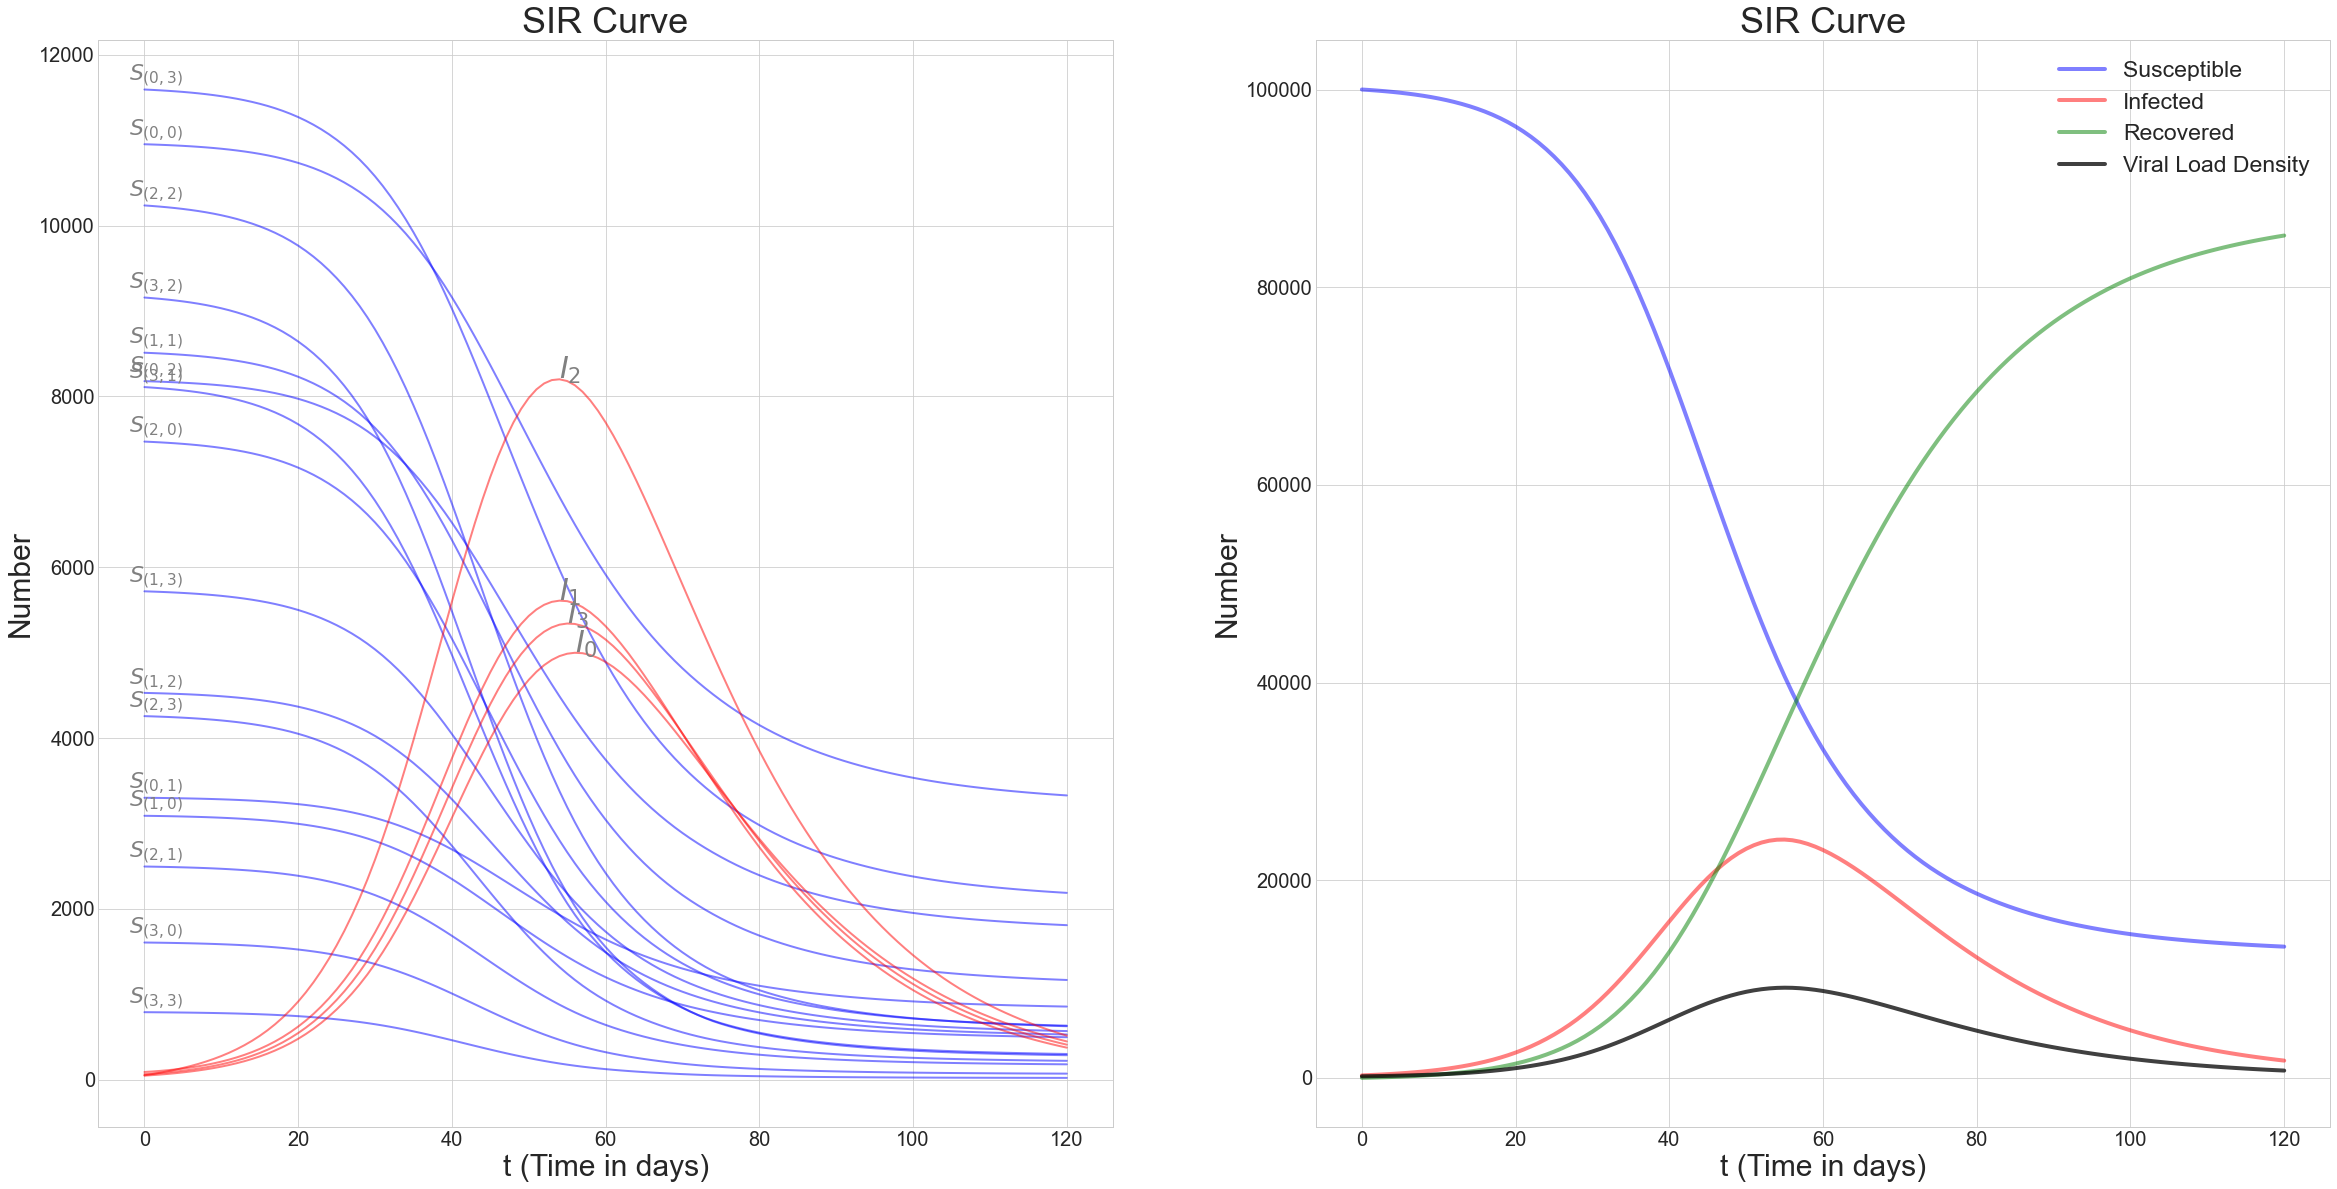

In [153]:
plt.style.use('seaborn-whitegrid')
plt.rc('font', size=25) 
fig, ax = plt.subplots(1, 2, sharex = True, figsize = (40,20) )
S00, S01, S02, S03,\
    S10,S11,S12,S13, \
    S20,S21,S22, S23, \
    S30,S31,S32,S33, \
    I1, I2, I3, I4, \
    I0, R0 = soln.y

all_S = [S00, S01, S02, S03,\
    S10,S11,S12,S13, \
    S20,S21,S22, S23, \
    S30,S31,S32,S33]
all_I = [I1,I2,I3,I4]

# Plot Susceptible vc
style = dict(size=22, color='gray')


for Svc, index in zip(all_S, product(range(4),range(4))):
    ax[0].plot(soln.t, Svc, 'b', alpha=0.5, lw=2, label='Susceptible')
    ax[0].text(-2, Svc[0] + 100, f"$S_{{{index[0],index[1]}}}$", **style)

# Plot Infected vc
for c, Ic in enumerate(all_I):
    max_ind = np.where(Ic == Ic.max())[0]
    ax[0].plot(soln.t, Ic, 'r', alpha=0.5, lw=2, label='Infected')
    ax[0].text(max_ind, Ic[max_ind], f"$I_{{{c}}}$", size = 30, color = 'gray')

# Plot Overall S, I, R
ax[1].plot(soln.t, np.sum(all_S, axis = 0), 'b', alpha=0.5, lw=4, label='Susceptible')
ax[1].plot(soln.t, np.sum(all_I, axis = 0),'r', alpha=0.5, lw=4, label='Infected')
ax[1].plot(soln.t, R0, 'g', alpha=0.5, lw=4, label='Recovered')
# Plot viral load density L
Lty = (I1 * L[0] + I2 * L[1] + I[3] * L[2] + I4 * L[3])
ax[1].plot(soln.t, Lty, 'black', alpha = 0.75, lw = 4, label = 'Viral Load Density')

ax[0].tick_params(axis='both', which='major', labelsize=20)
ax[0].set(xlabel = "t (Time in days)", ylabel = "Number", title = "SIR Curve")
ax[1].legend(fontsize = 23)
ax[1].tick_params(axis='both', which='major', labelsize=20)
ax[1].set(xlabel = "t (Time in days)", ylabel = "Number", title = "SIR Curve")



3) Do the shapes of S, I, R look similar to what you expected? Which of these plots is the “curve” people refer to when they say “flatten the curve”?

4) Do you observe that some Sv,c compartments converged to zero while others converged to a positive value? Why do you think that is?

5) Print the percentages of population that never got infected for all compartments (i.e. all values of v and c).


In [156]:
v = 0
c = 0
for Svc in all_S:
    print(f"S{v}{c}: {Svc[-1]/Svc[0]}")
    if c == 3:
        v +=1
        c = 0
    c += 1

S00: 0.30385930986884385
S01: 0.25925183318555345
S02: 0.22116861930870635
S03: 0.18864642323700023
S11: 0.16086522528162292
S12: 0.13712696724770584
S13: 0.11683742143621478
S21: 0.09949073472600328
S22: 0.08465625641671017
S23: 0.07196731535123997
S31: 0.06111166046891348
S32: 0.05182332054652795
S33: 0.043875674474910344
S41: 0.037075553858456
S42: 0.03125822575595577
S43: 0.02628312563766615


6) Multiply all the βv,c values by 1/4. What happened to the S, I, R plots? Did the “curve” flatten compared to the previous case? Print the percentages of population that never got infected with these βv,c values.

[Text(0.5, 0, 't (Time in days)'),
 Text(0, 0.5, 'Number'),
 Text(0.5, 1.0, 'SIR Curve')]

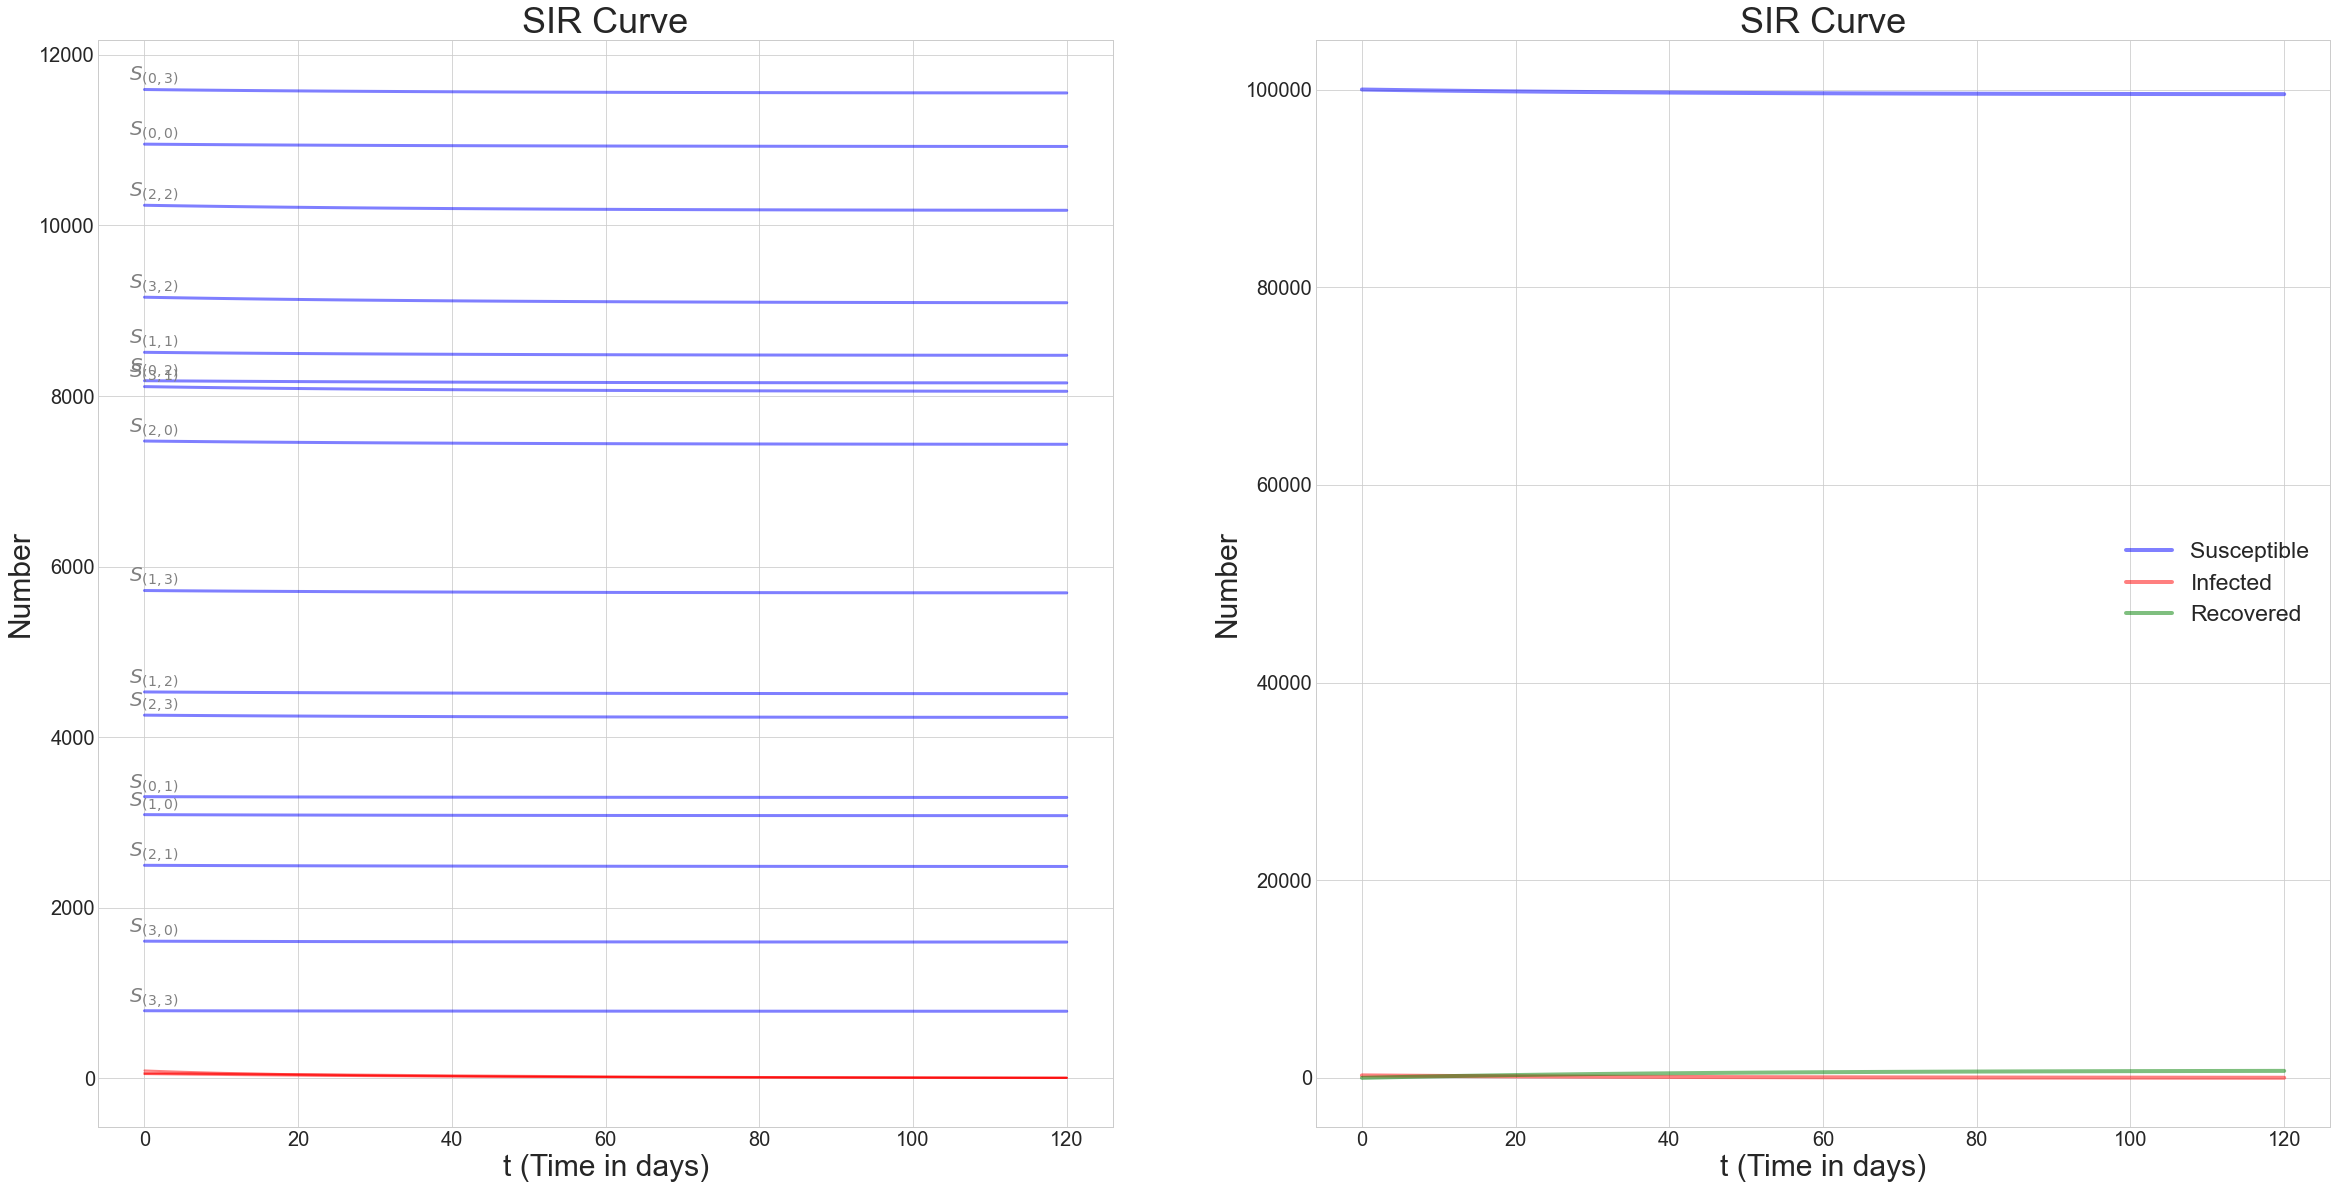

In [149]:
plt.rc('font', size=25) 
fig, ax = plt.subplots(1, 2, sharex = True, figsize = (40,20) )
# ax[0].set(xlabel = "t (Time in days)", ylabel = "Number",
#          title = "SIR Curve")
soln = solve_ivp(SIR, t, y0 = (S[0,0],S[0,1],S[0,2],S[0,3],
                               S[1,0],S[1,1],S[1,2],S[1,3],
                               S[2,0],S[2,1],S[2,2],S[2,3],
                               S[3,0],S[3,1],S[3,2],S[3,3],
                               I[0],I[1],I[2],I[3], I.sum(), R), 
                 dense_output = True, t_eval=np.arange(121),\
                 args = (L, N, beta/4, gamma) )
S00, S01, S02, S03,\
    S10,S11,S12,S13, \
    S20,S21,S22, S23, \
    S30,S31,S32,S33, \
    I1, I2, I3, I4, \
    I0, R0 = soln.y

all_S = [S00, S01, S02, S03,\
    S10,S11,S12,S13, \
    S20,S21,S22, S23, \
    S30,S31,S32,S33]
all_I = [I1,I2,I3,I4]

for Svc, index in zip(all_S, product(range(4),range(4))):
    ax[0].plot(soln.t, Svc, 'b', alpha=0.5, lw=2, label='Susceptible')
    ax[0].text(-2, Svc[0] + 100, f"$S_{{{index[0],index[1]}}}$", **style)

# Plot Infected vc
for c, Ic in enumerate(all_I):
    ax[0].plot(soln.t, Ic, 'r', alpha=0.5, lw=2, label='Infected')

ax[1].plot(soln.t, np.sum(all_S, axis = 0), 'b', alpha=0.5, lw=4, label='Susceptible')
ax[1].plot(soln.t, np.sum(all_I, axis = 0),'r', alpha=0.5, lw=4, label='Infected')
ax[1].plot(soln.t, R0, 'g', alpha=0.5, lw=4, label='Recovered')

ax[0].tick_params(axis='both', which='major', labelsize=20)
ax[0].set(xlabel = "t (Time in days)", ylabel = "Number", title = "SIR Curve")
ax[1].legend(fontsize = 23)
ax[1].tick_params(axis='both', which='major', labelsize=20)
ax[1].set(xlabel = "t (Time in days)", ylabel = "Number", title = "SIR Curve")


In [59]:
v = 0
c = 0
for Svc in all_S:
    print(f"S{v}{c}: {Svc[-1]/Svc[0]}")
    if c == 3:
        v +=1
        c = 0
    c += 1

S: v = 0, c = 0: 0.9975255455045224
S: v = 0, c = 1: 0.997196081268766
S: v = 0, c = 2: 0.996866725867394
S: v = 0, c = 3: 0.9965374792644626
S: v = 1, c = 1: 0.996208341424039
S: v = 1, c = 2: 0.9958793123102025
S: v = 1, c = 3: 0.9955503918870441
S: v = 2, c = 1: 0.995221580118667
S: v = 2, c = 2: 0.9948928769691868
S: v = 2, c = 3: 0.994564282402729
S: v = 3, c = 1: 0.994235796383433
S: v = 3, c = 2: 0.9939074188754496
S: v = 3, c = 3: 0.99357914984294
S: v = 4, c = 1: 0.9932509892500797
S: v = 4, c = 2: 0.992922937061054
S: v = 4, c = 3: 0.9925949932400605


## Part 1b

In [12]:
bdata = np.load("part1b.npz")

In [13]:
bdata.files

['N', 'Lc', 'Ic_0', 'gamma', 'L_validation', 'L_test', 'betas_validation']

In [72]:
N_b = bdata['N'] # Each node has population N
L_b = bdata['Lc']
I_b = bdata['Ic_0']
gamma_b = bdata['gamma']
L_validation = bdata['L_validation']
L_test = bdata['L_test']
betas_validation = bdata['betas_validation']
pmf = np.array([0.5,0.3,0.1,0.1,0.4,0.3,0.2,0.1,0.3,0.3,0.2,0.2,0.1,0.2,0.3,0.4])

In [15]:
def SIR_b(t, y, N, beta, gamma):
    
    Sv0, Sv1, Sv2, Sv3, I0, I1, I2, I3, R = y
    I = np.sum([I0,I1,I2,I3])
    
    dSv0dt = -beta[0] * Sv0 * I / N
    dSv1dt = -beta[1] * Sv1 * I / N
    dSv2dt = -beta[2] * Sv2 * I / N
    dSv3dt = -beta[3] * Sv3 * I / N
    
    dI0dt = -1 * dSv0dt - (gamma * I0)
    dI1dt = -1 * dSv1dt - (gamma * I1)
    dI2dt = -1 * dSv2dt - (gamma * I2)
    dI3dt = -1 * dSv3dt - (gamma * I3)
    
    dRdt = gamma * I
   
    return dSv0dt, dSv1dt, dSv2dt, dSv3dt,\
    dI0dt, dI1dt, dI2dt, dI3dt, dRdt

1) Using these distributions, total population sizes and observations of viral load densities L for 20 consecutive days (day 0 through day 19) for the 20 leaf nodes that are given to you, estimate the 16 parameters βv,c using grid search and MMSE on the “validation” data. In other words try to minimize MSE between Lvalidation and Lestimated. Compare the βv,c you estimated with the ground truth given in the file. This step is to make sure your code and logic works correctly.


In [ ]:
# Beta Grid Search

def beta_gridsearch(beta_grid, pmf, I_b, L, prev_beta_vc):
    '''Select what beta values you want to search for thru beta_grid for FIVE NODES
    e.g. beta_grid = np.linspace(0,1,21), pmf[0:4], I_b[0:5] for first five nodes'''
    beta_mmse= None 
    mmse = np.inf
    start_time = time()
    N = 50000
    L_b = [0.3,0.4,0.7,1]
    # Grid search for optimal values of beta 
    for (betav0, betav1, betav2, betav3) in product(beta_grid, beta_grid, beta_grid, beta_grid):
        # Check if beta values are greater as vulnerability increases and comorbidity increases, ignore
        # ignore product of beta values if conditions not satisfied
        bigger_than_prev_beta = (betav0 >= prev_beta_vc[0]) and betav1 >=(prev_beta_vc[1])\
        and (betav2 >= prev_beta_vc[2]) and (betav3 >=prev_beta_vc[3])
        
        if (betav0 <= betav1 <= betav2 <= betav3) and bigger_than_prev_beta:
            # If beta values valid, solve ODE with 
            beta = [betav0, betav1, betav2, betav3]
            nodes = 5
            mse = np.empty(5)
            for n in range(nodes):
                I0,I1,I2,I3 = I_b[n]
                I_total = np.sum([I0,I1,I2,I3])
                Sv0, Sv1, Sv2, Sv3 = pmf * (N - I_total )
                R = 0
                # Solve ODE
                soln_obj = solve_ivp(SIR_b, t_span = (0,19), \
                                     y0 = (Sv0, Sv1, Sv2, Sv3,
                                     I0,I1,I2,I3, R), \
                                     t_eval = np.arange(20), dense_output = True, \
                                     args = (N, beta, gamma_b))
                # Assign solutions from solution object
                Sv0_y, Sv1_y, Sv2_y, Sv3_y, I0_y, I1_y, I2_y, I3_y, R_y = soln_obj.y
                # Calculate sample L and MSE
                L_pred = np.sum(np.array([I0_y * L_b[0], I1_y * L_b[1],I2_y * L_b[2],I3_y * L_b[3]]), axis = 0)
                mse[n] = mean_squared_error(L_pred, L[n]) 
            # If sum MSE of five nodes is lower, store new betas
            sum_mse = mse.sum()
            if sum_mse < mmse:
                mmse = sum_mse
                beta_mmse = beta        
    end_time = time()
    print(f"Run time: {end_time - start_time:.2f} seconds")
    print(f"Estimated values are beta={beta_mmse}")
    print(f"MMSE = {mmse}\n")
    return beta_mmse

In [63]:
print("Beta values for vulnerability 1")
beta_mmse_1 = beta_gridsearch(np.linspace(0,1,21), pmf[0:4], I_b[0:5], L_validation[0:5], np.zeros(4))

print("Beta values for vulnerability 2")
beta_mmse_2 = beta_gridsearch(np.linspace(0,1,21), pmf[4:8], I_b[5:10], L_validation[5:10], [0.1,0.15,0.2,0.25])

print("Beta values for vulnerability 3")
beta_mmse_3 = beta_gridsearch(np.linspace(0,1,21), pmf[8:12], I_b[10:15], L_validation[10:15], [0.2,0.25,0.3,0.4])

print("Beta values for vulnerability 4")
beta_mmse_4 = beta_gridsearch(np.linspace(0,1,21), pmf[12:16], I_b[15:20], L_validation[15:20], [0.35,0.45,0.5,0.6])

Beta values for vulnerability 1
Run time: 204.75 seconds
Estimated values are beta=[0.1, 0.15000000000000002, 0.2, 0.25]
MMSE = 23.71262418237272

Beta values for vulnerability 2
Run time: 153.85 seconds
Estimated values are beta=[0.2, 0.25, 0.30000000000000004, 0.4]
MMSE = 640.5563821301458

Beta values for vulnerability 3
Run time: 115.86 seconds
Estimated values are beta=[0.35000000000000003, 0.45, 0.5, 0.6000000000000001]
MMSE = 33587.87126692951

Beta values for vulnerability 4
Run time: 59.51 seconds
Estimated values are beta=[0.4, 0.5, 0.6000000000000001, 0.8]
MMSE = 108784.70030528461



In [64]:
betas_validation == np.array([beta_mmse_1, beta_mmse_2, beta_mmse_3, beta_mmse_4]).round(2)

array([[ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True]])

2) Now use the “test” data (20 L values for 20 days) from the file and estimate the βv,c. This time you won’t have access to the ground truth βv,c values. Print the βv,c values you estimated.

In [36]:
beta_test_1 = beta_gridsearch(np.linspace(0,1,21), pmf[0:4], I_b[0:5], L_test[0:5], np.zeros(4))
beta_test_2 = beta_gridsearch(np.linspace(0,1,21), pmf[4:8], I_b[5:10], L_test[5:10], beta_test_1)
beta_test_3 = beta_gridsearch(np.linspace(0,1,21), pmf[8:12], I_b[10:15], L_test[10:15], beta_test_2)
beta_test_4 = beta_gridsearch(np.linspace(0,1,21), pmf[12:16], I_b[15:20], L_test[15:20], beta_test_3)

Run time: 205.35 seconds
Estimated values are beta=[0.05, 0.1, 0.15000000000000002, 0.25]
MMSE = 12.067391760667306

Run time: 179.80 seconds
Estimated values are beta=[0.2, 0.25, 0.30000000000000004, 0.4]
MMSE = 835.5508455932961

Run time: 115.61 seconds
Estimated values are beta=[0.4, 0.45, 0.5, 0.6000000000000001]
MMSE = 49661.00889063452

Run time: 49.66 seconds
Estimated values are beta=[0.5, 0.7000000000000001, 0.7000000000000001, 0.8500000000000001]
MMSE = 118857.42255776864



3) Use the βv,c you found to predict the disease behaviour for the future. Solve the equations for 100 days and plot S, I, R, L values for the first node in each social vulnerability case. On L graphs, also plot the corresponding observed values for the first 20 days (with a circle marker).


In [78]:
all_S = np.zeros((4,100))
all_I = np.zeros((4,100))
all_L = np.zeros((4,100))
all_R = np.zeros((4,100))
beta_test_grid = np.stack((beta_test_1,beta_test_2,beta_test_3,beta_test_4), axis = 0)
for (node,pmf_start, pmf_end, i, beta) in zip(range(0,20,5),range(0,16,4),range(4,20,4),range(4), beta_test_grid):
    # Initial values
    N = 50000
    I0,I1,I2,I3 = I_b[node]
    I_total = np.sum([I0,I1,I2,I3])
    Sv0, Sv1, Sv2, Sv3 = pmf[pmf_start:pmf_end] * (N - I_total)
    R = 0
    soln = solve_ivp(SIR_b, t_span = (0,99), \
                                         y0 = (Sv0, Sv1, Sv2, Sv3,
                                         I0,I1,I2,I3, R), \
                                         t_eval = np.arange(100), dense_output = True, \
                                         args = (N, beta, gamma_b))
    Sv0_y, Sv1_y, Sv2_y, Sv3_y, I0_y, I1_y, I2_y, I3_y, R_y = soln.y
    local_L_pred = np.sum(np.array([I0_y * L_b[0], I1_y * L_b[1],I2_y * L_b[2],I3_y * L_b[3]]), axis = 0)
    local_S = np.sum(np.array([Sv0_y, Sv1_y, Sv2_y, Sv3_y]) ,axis=0)
    local_I = np.sum(np.array([I0_y, I1_y, I2_y, I3_y]),axis=0)
    all_S[i, :] = local_S
    all_I[i, :] = local_I
    all_L[i, :] = local_L_pred
    all_R[i] = R_y

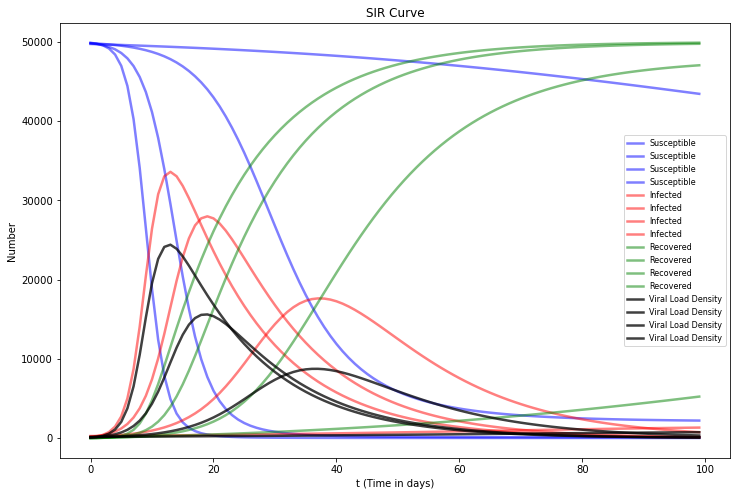

In [80]:
fig, ax = plt.subplots(figsize = (12,8))
ax.tick_params(axis='both', which='major')
ax.set(xlabel = "t (Time in days)", ylabel = "Number", title = "SIR Curve")
t = np.arange(100)
# Plot Overall S, I, R
for s in all_S:
    ax.plot(t, s, 'b', alpha=0.5, lw=2.5, label='Susceptible')
for i in all_I:
    ax.plot(t, i,'r', alpha=0.5, lw=2.5, label='Infected')
for r in all_R:
    ax.plot(t, r, 'g', alpha=0.5, lw=2.5, label='Recovered')
# Plot viral load density L_pred
for l in all_L:
    ax.plot(t, l, 'black', alpha = 0.75, lw = 2.5, label = 'Viral Load Density')
ax.legend(fontsize = 8)